<a href="https://colab.research.google.com/github/brauliosba/Machine-Learning---TA2/blob/main/TB2_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [176]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [223]:
# keras import
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import *
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# hyperparameter optimization
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# others
from sklearn.metrics import classification_report

In [208]:
n_epochs = 10
n_cv = 3
validation_ratio = 0.10

In [179]:
path = "/content/drive/My Drive/Machine Learning/Datasets/train.csv"

In [197]:
data_set = pd.read_csv(path)
print(data_set.shape)

(42000, 785)


In [198]:
# segregate training data set in pixel features and label
y = data_set['label']
X = data_set.drop(labels = ['label'], axis=1) 
# free memory
del data_set

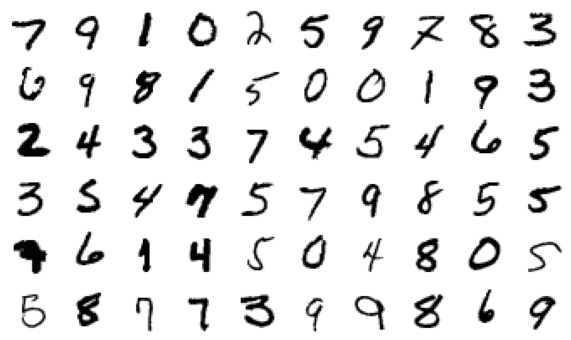

In [199]:
# show multiple images chosen randomly 
fig, axs = plt.subplots(6, 10, figsize=(10, 6)) # 6 rows of 10 images

for ax in axs.flat:
    i = randrange(X.shape[0])
    ax.imshow(X.loc[i].values.reshape(28, 28), cmap='gray_r')
    ax.set_axis_off()

In [200]:
# Normalize pixel value to range 0 to 1
X = X / 255.0

In [203]:
# Reshape the images
img_size = 28
X_cnn = X.values.reshape(-1, img_size, img_size, 1)
# check 
print(X_cnn.shape)

X_train, X_val, y_train, y_val = train_test_split(X_cnn, y, test_size = validation_ratio)

(42000, 28, 28, 1)


In [210]:
def create_cnn_model(pool_type='max', conv_activation='sigmoid', dropout_rate=0.10):
    # create model
    model = Sequential()
    
    # first layer: convolution
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1))) 
        
    # second series of layers: convolution, pooling, and dropout
    model.add(Conv2D(32, kernel_size=(5, 5), activation=conv_activation))  
    if pool_type == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if pool_type == 'average':
        model.add(AveragePooling2D(pool_size=(2, 2)))
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate))     
    
    # third series of layers: convolution, pooling, and dropout    
    model.add(Conv2D(64, kernel_size=(3, 3), activation=conv_activation))   # 32   
    if pool_type == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if pool_type == 'average':
        model.add(AveragePooling2D(pool_size=(2, 2)))
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate))     
      
    # fourth series
    model.add(Flatten())         
    model.add(Dense(64, activation='sigmoid')) # 64
    # add a dropout layer if rate is not null    
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate)) 
        
    model.add(Dense(10, activation='softmax'))
    
    # Compile model
    model.compile( 
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        )    
    return model

cnn = create_cnn_model()

cnn.compile(
  optimizer='adam',
  loss='categorical_crossentropy',  
  metrics=['accuracy'],
)

cnn.summary()

Model: "sequential_561"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 24, 24, 16)        416       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 20, 20, 32)        12832     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_558 (Dropout)        (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_559 (Dropout)        (None, 4, 4, 64)       

In [222]:
early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=5, restore_best_weights=True)

# Train the default CNN model
history = cnn.fit(
    X_train,
    to_categorical(y_train),
    epochs=n_epochs,  
    validation_data=(X_val, to_categorical(y_val)), 
    batch_size=32,
    callbacks = [early_stop]
)

Epoch 1/10
1182/1182 [==============================] - 76s 64ms/step - loss: 0.0228 - accuracy: 0.9929 - val_loss: 0.0269 - val_accuracy: 0.9921
Epoch 2/10
1182/1182 [==============================] - 76s 64ms/step - loss: 0.0202 - accuracy: 0.9938 - val_loss: 0.0248 - val_accuracy: 0.9931
Epoch 3/10
1182/1182 [==============================] - 76s 64ms/step - loss: 0.0177 - accuracy: 0.9943 - val_loss: 0.0342 - val_accuracy: 0.9900
Epoch 4/10
1182/1182 [==============================] - 76s 64ms/step - loss: 0.0168 - accuracy: 0.9945 - val_loss: 0.0318 - val_accuracy: 0.9907
Epoch 5/10
1182/1182 [==============================] - 77s 65ms/step - loss: 0.0157 - accuracy: 0.9951 - val_loss: 0.0271 - val_accuracy: 0.9912
Epoch 6/10
1182/1182 [==============================] - 76s 64ms/step - loss: 0.0132 - accuracy: 0.9957 - val_loss: 0.0273 - val_accuracy: 0.9936
Epoch 7/10
1182/1182 [==============================] - 79s 67ms/step - loss: 0.0134 - accuracy: 0.9962 - val_loss: 0.0250 -

In [232]:
y_pred = cnn.predict(X_val, batch_size=32, verbose=1)
y_pred_cate = np.argmax(y_pred, axis=1)
print(classification_report(y_val, y_pred_cate))

132/132 [==============================] - 2s 16ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       405
           1       0.99      1.00      0.99       480
           2       0.99      1.00      0.99       443
           3       1.00      0.99      1.00       435
           4       1.00      1.00      1.00       431
           5       0.99      1.00      0.99       398
           6       0.99      0.99      0.99       388
           7       1.00      0.97      0.98       432
           8       0.99      0.98      0.99       400
           9       0.99      1.00      1.00       388

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200



In [233]:
# extract train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = validation_ratio)

In [234]:
# define model
mlp = Sequential()
mlp.add(Dense(128, activation='relu', input_shape=(784,)))
mlp.add(Dense(64, activation='sigmoid'))  
mlp.add(Dense(10, activation='softmax'))

mlp.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

mlp.summary()

Model: "sequential_562"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_588 (Dense)            (None, 128)               100480    
_________________________________________________________________
dense_589 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_590 (Dense)            (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [238]:
early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=5, restore_best_weights=True)

history = mlp.fit(
    X_train,
    to_categorical(y_train),
    epochs = n_epochs,  
    validation_data = (X_val, to_categorical(y_val)),
    batch_size = 32,
    callbacks = [early_stop]
)

Epoch 1/10
1182/1182 [==============================] - 3s 3ms/step - loss: 0.1450 - accuracy: 0.9574 - val_loss: 0.1500 - val_accuracy: 0.9543
Epoch 2/10
1182/1182 [==============================] - 3s 2ms/step - loss: 0.0927 - accuracy: 0.9722 - val_loss: 0.1230 - val_accuracy: 0.9640
Epoch 3/10
1182/1182 [==============================] - 3s 2ms/step - loss: 0.0659 - accuracy: 0.9801 - val_loss: 0.1085 - val_accuracy: 0.9681
Epoch 4/10
1182/1182 [==============================] - 3s 2ms/step - loss: 0.0494 - accuracy: 0.9854 - val_loss: 0.1163 - val_accuracy: 0.9669
Epoch 5/10
1182/1182 [==============================] - 3s 2ms/step - loss: 0.0389 - accuracy: 0.9876 - val_loss: 0.1033 - val_accuracy: 0.9683
Epoch 6/10
1182/1182 [==============================] - 3s 2ms/step - loss: 0.0278 - accuracy: 0.9921 - val_loss: 0.0944 - val_accuracy: 0.9729
Epoch 7/10
1182/1182 [==============================] - 3s 2ms/step - loss: 0.0237 - accuracy: 0.9932 - val_loss: 0.0965 - val_accuracy:

In [239]:
y_pred = mlp.predict(X_val, batch_size=32, verbose=1)
y_pred_cate = np.argmax(y_pred, axis=1)
print(classification_report(y_val, y_pred_cate))

132/132 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       422
           1       0.98      0.99      0.99       460
           2       0.97      0.98      0.97       425
           3       0.97      0.97      0.97       432
           4       0.97      0.98      0.97       394
           5       0.99      0.93      0.96       373
           6       0.96      0.99      0.98       441
           7       0.98      0.98      0.98       443
           8       0.95      0.96      0.96       409
           9       0.97      0.96      0.96       401

    accuracy                           0.97      4200
   macro avg       0.97      0.97      0.97      4200
weighted avg       0.97      0.97      0.97      4200

